This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noise-free image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

In [3]:
function translate_tip_peak(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)
    
    p_max, id = findmax(P)
    p_min = minimum(P)

    P_new = deepcopy(P)
    P_new .= p_min - p_max
    
    pxmin = max(1-xc, 1-id[1])
    pymin = max(1-yc, 1-id[2])
    pxmax = min(tip_xsiz-xc, tip_xsiz-id[1])
    pymax = min(tip_ysiz-yc, tip_ysiz-id[2])
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id[1]+px, id[2]+py] - p_max
        end
    end
    return P_new
end

translate_tip_peak (generic function with 1 method)

In [4]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    if all(weight_x .< 10.0^(-8))
        weight_x .= 1.0
    end
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    if all(weight_y .< 10.0^(-8))
        weight_y .= 1.0
    end
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

## Define Flux layers

In [5]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [44]:
images_randn_copy = deepcopy(images)

#lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
loss_over_lambdas = []
P_over_lambdas = []

for lambda in lambdas
    @info lambda

    m = IOpen(9, 9)

    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
    loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

    ps = Flux.params(m)

    train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:20], label=images_randn[1:20]), batchsize=1, shuffle=false);
    test_loader = Flux.Data.DataLoader((data=images_randn_copy[21:30], label=images_randn[21:30]), batchsize=1);

    #opt = ADAM(0.1)
    opt = ADAMW(1.0, (0.9, 0.999), lambda)
    
    loss_train = []
    loss_test = []

    for epoch in 1:100
        for (x, y) in train_loader
            gs = gradient(() -> loss(x, y), ps)
            Flux.Optimise.update!(opt, ps, gs)
            m.P .= min.(m.P, 0.0)
            m.P .= translate_tip_mean(m.P)
        end
        push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
        push!(loss_test, loss(images_randn_copy[21:30], images_randn[21:30]))
    end

    push!(loss_over_lambdas, loss_train[end])
    push!(P_over_lambdas, m.P)
end

┌ Info: 1.0e-7
└ @ Main In[44]:9
┌ Info: 1.0e-6
└ @ Main In[44]:9
┌ Info: 1.0e-5
└ @ Main In[44]:9
┌ Info: 0.0001
└ @ Main In[44]:9
┌ Info: 0.001
└ @ Main In[44]:9
┌ Info: 0.01
└ @ Main In[44]:9


In [45]:
loss_over_lambdas

6-element Vector{Any}:
  10.12622361827185
  10.113553016779184
  10.217393641636345
  10.687693353555598
  19.357767221522174
 119.09304908074421

In [47]:
gr()

Plots.GRBackend()

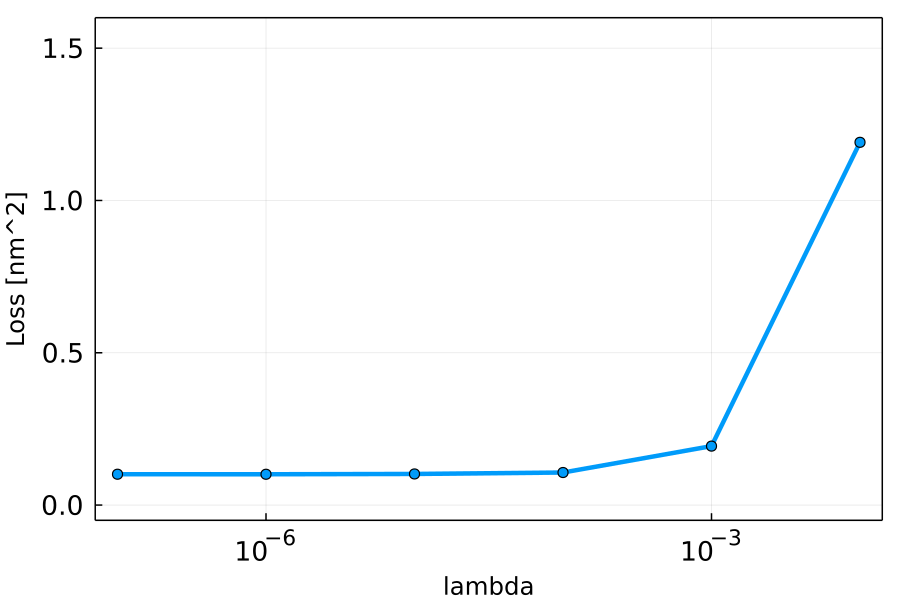

In [62]:
p = plot(lambdas, loss_over_lambdas / 100.0, xaxis=:log, framestyle = :box, xlabel="lambda λ", ylabel="loss [nm^2]", fontsize=35, label=nothing, linewidth=3.0, markershape=:circle, dpi=150, fmt=:png, color=1,
         xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!(-0.05, 1.6)
xlabel!("lambda", fontsize=35)
p = ylabel!("Loss [nm^2]", fontsize=35)

In [63]:
savefig(p, "blindtip_opening01.png")

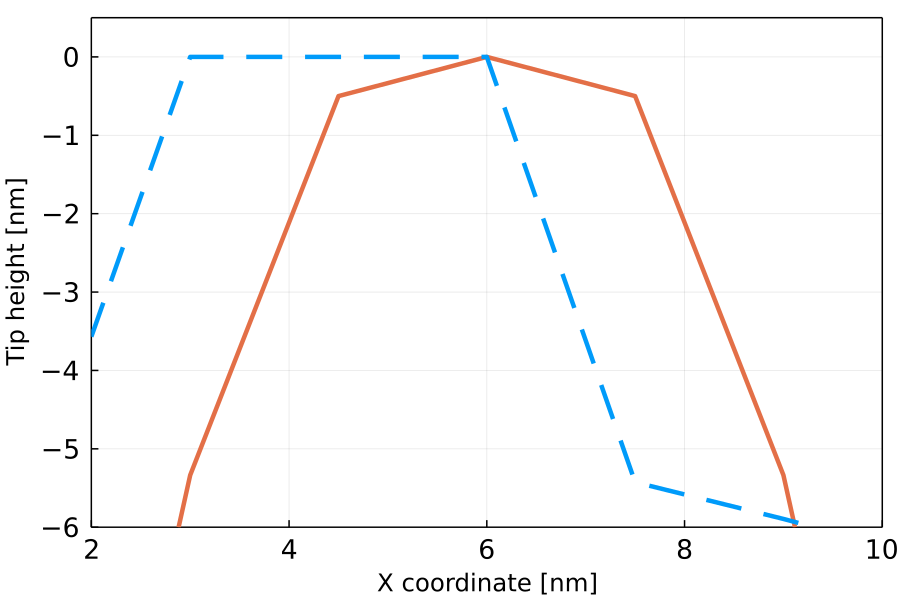

In [123]:
plot(collect(1:9) .* resolution / 10.0, tip[4, :] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
p = plot!(collect(1:9) .* resolution / 10.0, translate_tip_mean(P_over_lambdas[5])[4, :] / 10.0, linewidth=3, color=1, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, legend=nothing)

ylims!((-6, 0.5))
xlims!((2, 10))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [65]:
savefig(p, "blindtip_opening02.png")

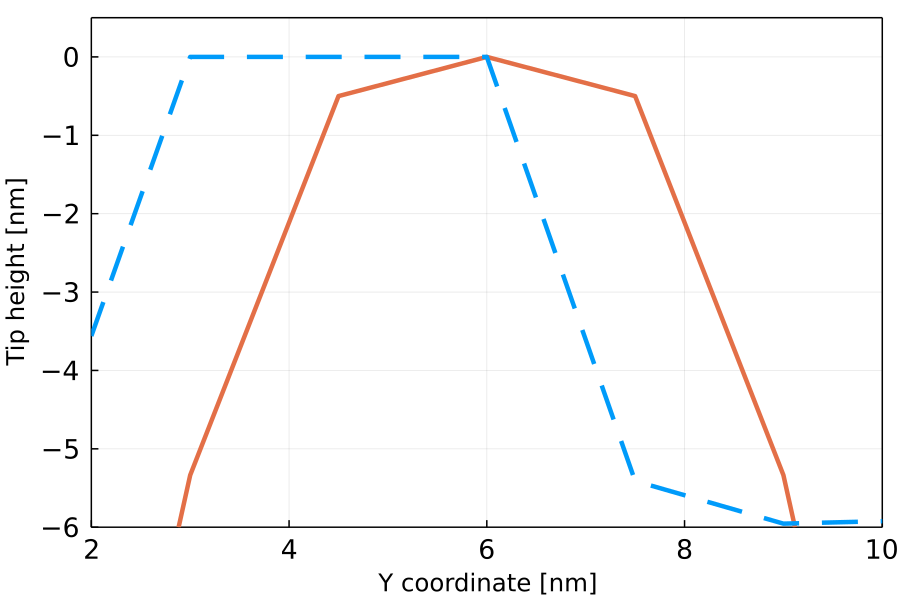

In [120]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 4] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
plot!(collect(1:9) .* resolution / 10.0, translate_tip_mean(P_over_lambdas[5])[:, 4] / 10.0, linewidth=3, color=1, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, legend=nothing)
ylims!((-6, 0.5))
xlims!((2, 10))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [69]:
savefig(p, "blindtip_opening03.png")

In [90]:
pyplot()

Plots.PyPlotBackend()

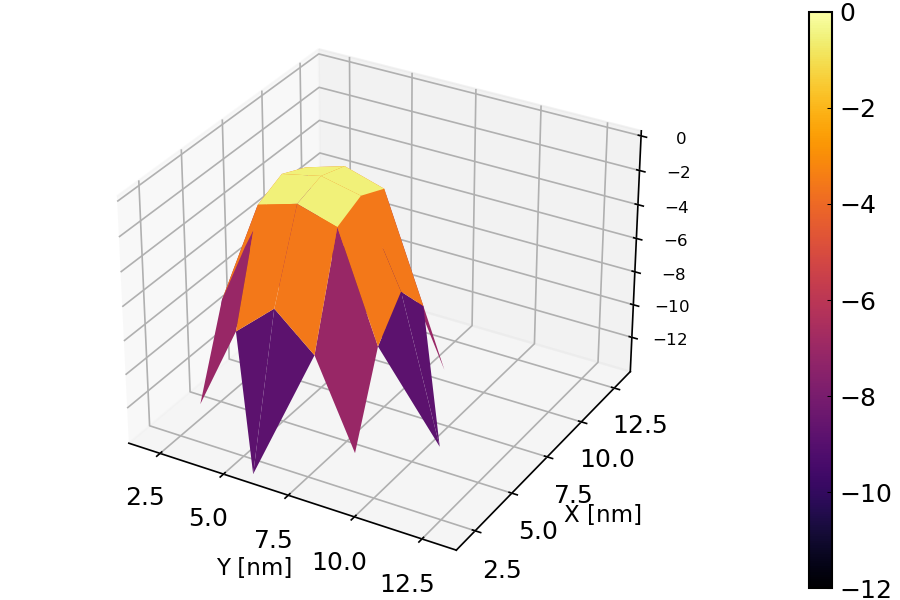

In [91]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:9) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0), 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [92]:
savefig(p, "blindtip_opening04.png")

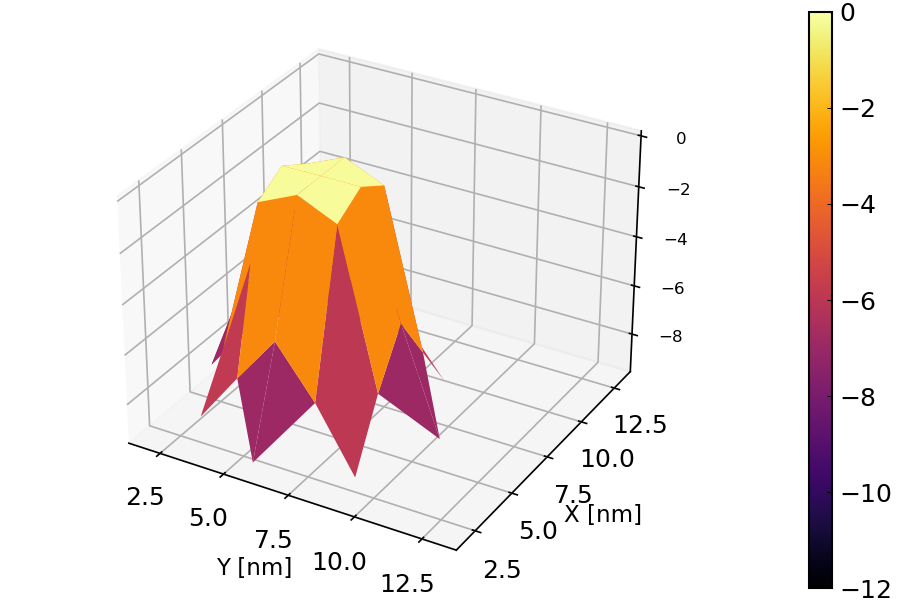

In [93]:
tip_tmp = deepcopy(P_over_lambdas[1])
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:9) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [94]:
savefig(p, "blindtip_opening05.png")

In [95]:
gr()

Plots.GRBackend()

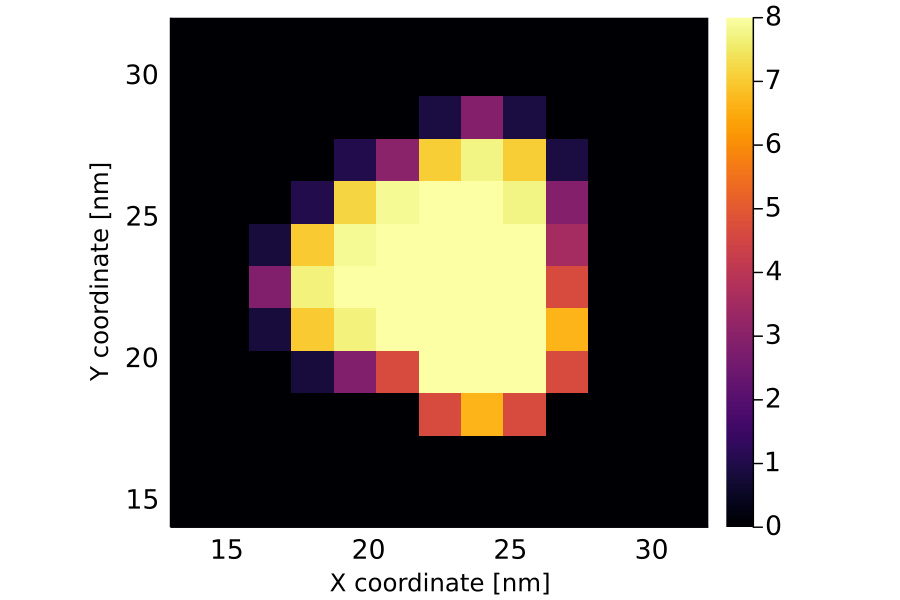

In [79]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [80]:
savefig(p, "blindtip_opening06.png")

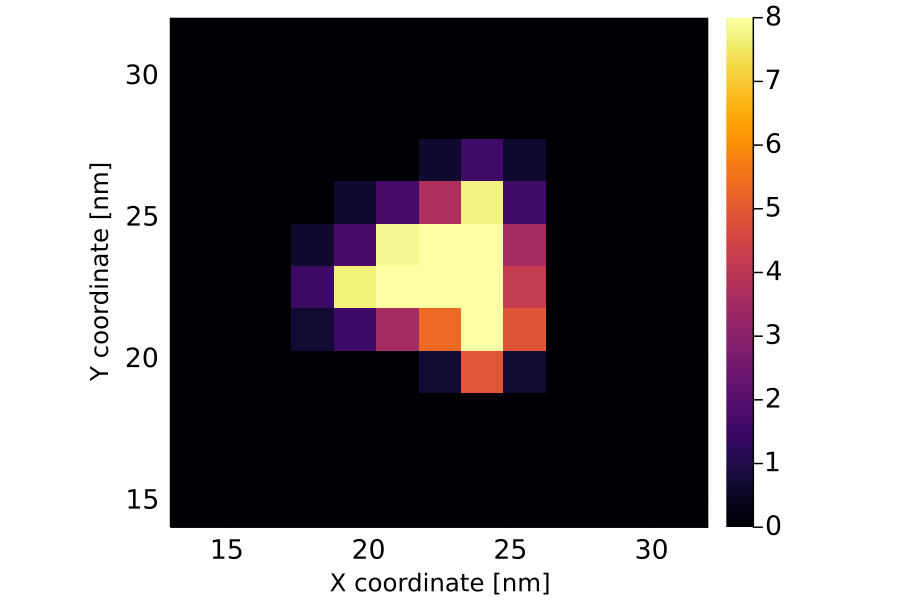

In [86]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images[1], translate_tip_mean(P_over_lambdas[1])) / 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [85]:
savefig(p, "blindtip_opening07.png")

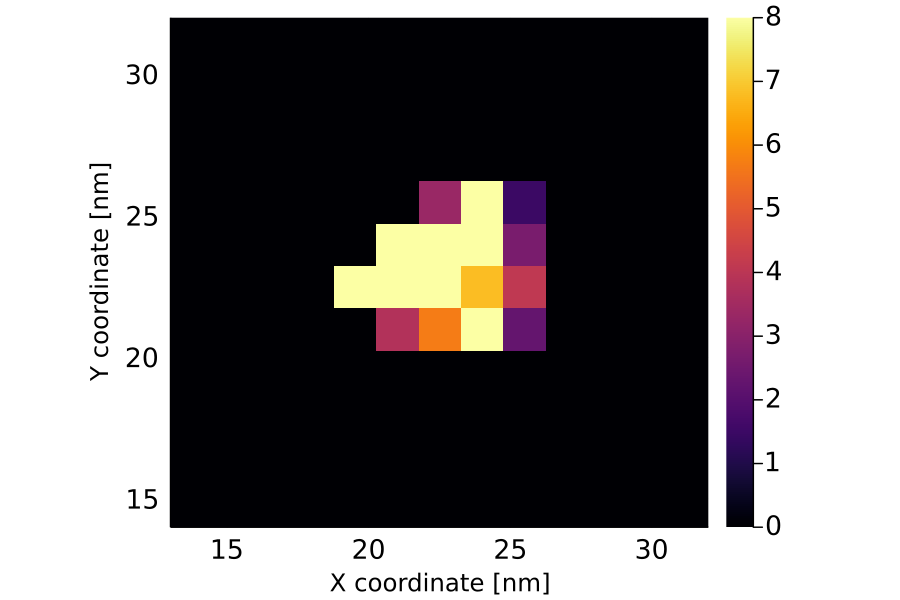

In [88]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png, aspect_ratio=:equal, 
            xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [89]:
savefig(p, "blindtip_opening08.png")

# Correlations

In [138]:
crosscor(image1, image2) = mean((image1 .- mean(image1)) .* (image2 .- mean(image2))) / (std(image1) * std(image2))
#pixel_rmsd(image1, image2) = sqrt(mean((image1 .- image2).^2))

function pixel_rmsd(image1, image2; cutoff = -80.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -2:2, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(lambdas), 2)
count = 0
for it = 1:length(lambdas)
    c = pixel_rmsd(tip, P_over_lambdas[it])
    count += 1
    diff_tip[count, 1] = lambdas[it]
    diff_tip[count, 2] = c
end

In [139]:
gr()

Plots.GRBackend()

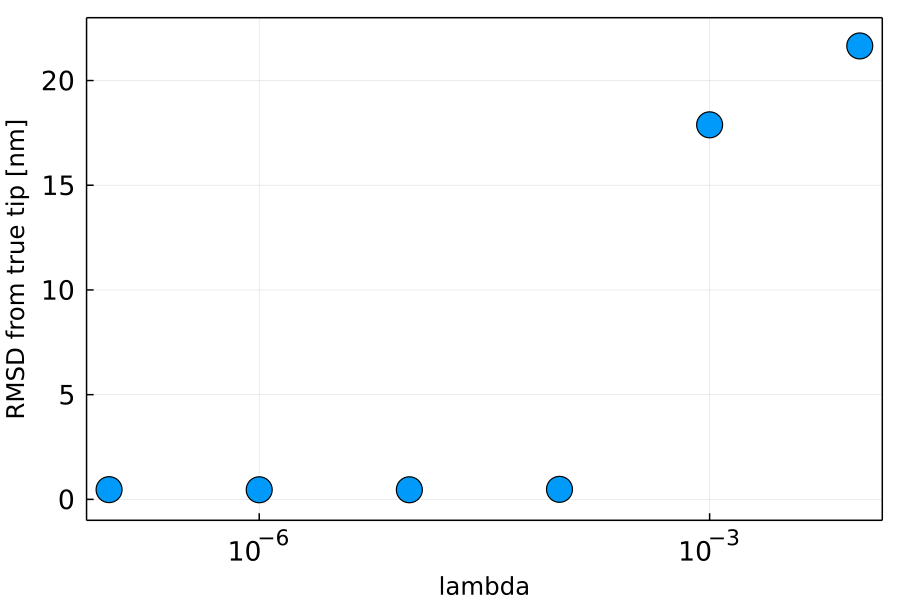

In [141]:
scatter(diff_tip[:, 1], diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12, markersize=10, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
ylims!(-1, 23)

In [142]:
diff_surf = zeros(Float64, length(lambdas)*length(images), 2)
count = 0

function pixel_rmsd(image1, image2; cutoff = 0.0)
    #id = (image1 .> cutoff) .| (image2 .> cutoff)

    rmsd_min = Inf64
    for du = -2:2, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1 .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

for it = 1:length(lambdas)
    for iframe = 1:length(images)
        c = pixel_rmsd(surfs[iframe], ierosion(images[iframe], P_over_lambdas[it]))
        count += 1
        diff_surf[count, 1] = lambdas[it]
        diff_surf[count, 2] = c
    end
end

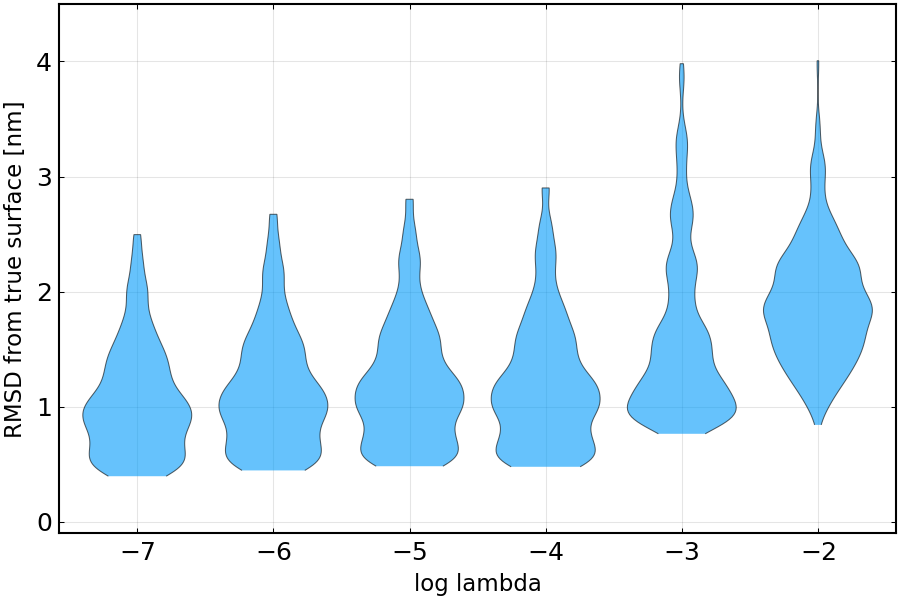

In [143]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, ylim=(-0.1, 4.5),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log lambda", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=1)

#ylims!(-0.1, 4.5)

# Save results

In [145]:
using BSON: @save, @load

@save "blindtip_opening.bson" tip lambdas P_over_lambdas
@save "blindtip_opening_rmsd.bson" diff_tip diff_surf